<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd

import os
import platform

import re
import unicodedata
import string

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
urlsSubtitulosADescargar = [
    'https://subs.argenteam.net/Star.Wars(1977)-aRGENTeaM-55.zip', # IV
    'https://subs.argenteam.net/Star.Wars.Episode.V(1980)-aRGENTeaM-30898.zip', # V
    'https://subs.argenteam.net/Star.Wars.Episode.VI(1983)-aRGENTeaM-30903.zip', # VI
    'https://subs.argenteam.net/Star.Wars.Episode.I(1999)-aRGENTeaM-30889.zip', # I
    'https://subs.argenteam.net/Star.Wars.Episode.II(2002)-aRGENTeaM-30893.zip', # II
    'https://subs.argenteam.net/Star.Wars.Episode.III(2005)-aRGENTeaM-3597.zip', # III
    'https://subs.argenteam.net/Star.Wars.Episode.VII-The.Force.Awakens.(2015)-aRGENTeaM-60426.zip', # VII
    'https://subs.argenteam.net/Star.Wars.Episode.VIII-The.Last.Jedi.(2017)-aRGENTeaM-71696.zip', # VIII
    'https://subs.argenteam.net/Star.Wars.Episode.IX-The.Rise.of.Skywalker.(2019)-aRGENTeaM-80480.zip', # IX
]

In [ ]:
# Descargar la carpeta de dataset
if os.access('./subs_dataset', os.F_OK) is False:
  # descargo los subtitulos
  for url in urlsSubtitulosADescargar:
    print(url)
    # obtengo nombre documento
    nombreDocumento = url.split('/')[-1]
    print(nombreDocumento)
    # descargo como .zip
    !wget {'"'+ url +'"'}
    # descomprimo
    !unzip {'"'+ nombreDocumento +'"'} -d './subs_dataset'
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# Posibles bandas
srtALeer = os.listdir("./subs_dataset/")

In [ ]:
# lee el primer subtitulo
df = pd.read_csv("./subs_dataset/" + srtALeer[0], sep='/n', header=None, encoding='latin-1')
# elimina lineas con '-->' y la superior
df.drop(df[df[0].str.contains('-->')].index - 1 , inplace = True) #quita numeros
df.drop(df[df[0].str.contains('-->')].index , inplace = True) #quita timepos
df.drop(df[df[0].str.contains('www.argenteam.net')].index , inplace = True) #quita marcas
df.drop(df[df[0].str.contains('Subtítulos por aRGENTeaM')].index , inplace = True) #quita marcas

# lee el resto y los agrega
for srlFile in srtALeer[1:]:
  # lee srt
  dfTemp = pd.read_csv("./subs_dataset/" + srlFile, sep='/n', header=None, encoding='latin-1')

  # elimina lineas con '-->' y la superior
  dfTemp.drop(dfTemp[dfTemp[0].str.contains('-->')].index - 1 , inplace = True) #quita numeros
  dfTemp.drop(dfTemp[dfTemp[0].str.contains('-->')].index , inplace = True) #quita timepos
  dfTemp.drop(dfTemp[dfTemp[0].str.contains('www.argenteam.net')].index , inplace = True) #quita marcas
  dfTemp.drop(dfTemp[dfTemp[0].str.contains('Subtítulos por aRGENTeaM')].index , inplace = True) #quita marcas
  # los agrega al df
  df = df.append(dfTemp, ignore_index=False)

df = df.reset_index(drop=True)
print(df.shape)
df.head()

(15455, 1)


<ipython-input-44-6306d92569c4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("./subs_dataset/" + srtALeer[0], sep='/n', header=None, encoding='latin-1')
<ipython-input-44-6306d92569c4>:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfTemp = pd.read_csv("./subs_dataset/" + srlFile, sep='/n', header=None, encoding='latin-1')
<ipython-input-44-6306d92569c4>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=False)
<ipython-input-44-6306d92569c4>:12: ParserWarni

,0
0,Hace mucho tiempo en una galaxia
1,"muy, muy lejana..."
2,Episodio VII
3,EL DESPERTAR DE LA FUERZA
4,Luke Skywalker ha desaparecido.


In [ ]:
print("Cantidad de documentos:", df.shape)

Cantidad de documentos: (15455, 1)


In [ ]:
# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quita los <i> e </i>
    patron = r'<\/?i>'  # Expresión regular para encontrar <i> o </i>
    text = re.sub(patron, '', text)  # Reemplazar las ocurrencias de <i> y </i> con una cadena vacía
    # quita las stopWords

    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
# limpia cada frace del dataframe
df[0] = df[0].apply( lambda x: (preprocess_clean_text( x )) )
df.head(10)

,0
0,Hace mucho tiempo en una galaxia
1,muy muy lejana
2,Episodio VII
3,EL DESPERTAR DE LA FUERZA
4,Luke Skywalker ha desaparecido
5,En su ausencia la siniestra
6,PRIMERA ORDEN ha surgido
7,de las cenizas del Imperio
8,y no descansara hasta
9,que Skywalker el ultimo Jedi


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [ ]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [ ]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Hace mucho tiempo en una galaxia'

In [ ]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['hace', 'mucho', 'tiempo', 'en', 'una', 'galaxia']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [ ]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['hace', 'mucho', 'tiempo', 'en', 'una', 'galaxia'], ['muy', 'muy', 'lejana']]

In [ ]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['hace', 'mucho', 'tiempo', 'en'], ['mucho', 'tiempo', 'en', 'una']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[4, 1, 2, 3], [1, 2, 3, 5]]

In [ ]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

2


In [ ]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

5


In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'mucho': 1, 'tiempo': 2, 'en': 3, 'hace': 4, 'una': 5}


In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'en': 2, 'hace': 1, 'mucho': 2, 'tiempo': 2, 'una': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Hace mucho tiempo en una galaxia
1                       muy muy lejana
2                         Episodio VII
3            EL DESPERTAR DE LA FUERZA
4       Luke Skywalker ha desaparecido
5          En su ausencia la siniestra
6             PRIMERA ORDEN ha surgido
7           de las cenizas del Imperio
8                y no descansara hasta
9         que Skywalker el ultimo Jedi
10                 haya sido destruido
11                     Con el apoyo de
12                        la REPUBLICA
13              la General Leia Organa
14     dirige una valiente RESISTENCIA
15            Desesperadamente busca a
Name: 0, dtype: object

In [ ]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Hace mucho tiempo en una galaxia muy muy lejana Episodio VII EL DESPERTAR DE LA FUERZA Luke Skywalker ha desaparecido En su ausencia la siniestra PRIMERA ORDEN ha surgido de las cenizas del Imperio y no descansara hasta que Skywalker el ultimo Jedi haya sido destruido Con el apoyo de la REPUBLICA la General Leia Organa dirige una valiente RESISTENCIA Desesperadamente busca a su hermano Luke con el fin de obtener su ayuda para restaurar la paz y la justicia en la galaxia Leia ha enviado a su piloto mas audaz en una mision secreta a Jakku donde un viejo aliado ha descubierto una pista del paradero de Luke Esto comenzara a enderezar las cosas Viaje muy lejos y vi mucho como para ignorar la desesperacion en la galaxia Sin los Jedi no puede haber equilibro en la Fuerza Gracias a ti ahora tenemos una oportunidad Hace mucho que la General quiere esto La General Para mi ella es de la realeza Claro que si Tenemos compania Tienes que esconderte Tu tienes que irte Vete Vamos BB apurate Disparale

In [ ]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['hace',
 'mucho',
 'tiempo',
 'en',
 'una',
 'galaxia',
 'muy',
 'muy',
 'lejana',
 'episodio',
 'vii',
 'el',
 'despertar',
 'de',
 'la',
 'fuerza',
 'luke',
 'skywalker',
 'ha',
 'desaparecido']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 62219


In [ ]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['hace', 'mucho', 'tiempo', 'en'],
 ['mucho', 'tiempo', 'en', 'una'],
 ['tiempo', 'en', 'una', 'galaxia'],
 ['en', 'una', 'galaxia', 'muy'],
 ['una', 'galaxia', 'muy', 'muy'],
 ['galaxia', 'muy', 'muy', 'lejana'],
 ['muy', 'muy', 'lejana', 'episodio'],
 ['muy', 'lejana', 'episodio', 'vii'],
 ['lejana', 'episodio', 'vii', 'el'],
 ['episodio', 'vii', 'el', 'despertar'],
 ['vii', 'el', 'despertar', 'de'],
 ['el', 'despertar', 'de', 'la'],
 ['despertar', 'de', 'la', 'fuerza'],
 ['de', 'la', 'fuerza', 'luke'],
 ['la', 'fuerza', 'luke', 'skywalker'],
 ['fuerza', 'luke', 'skywalker', 'ha'],
 ['luke', 'skywalker', 'ha', 'desaparecido'],
 ['skywalker', 'ha', 'desaparecido', 'en'],
 ['ha', 'desaparecido', 'en', 'su'],
 ['desaparecido', 'en', 'su', 'ausencia']]

In [ ]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[141, 54, 69, 7],
 [54, 69, 7, 20],
 [69, 7, 20, 142],
 [7, 20, 142, 44],
 [20, 142, 44, 44],
 [142, 44, 44, 746],
 [44, 44, 746, 747],
 [44, 746, 747, 3621],
 [746, 747, 3621, 6],
 [747, 3621, 6, 2376],
 [3621, 6, 2376, 2],
 [6, 2376, 2, 4],
 [2376, 2, 4, 52],
 [2, 4, 52, 55],
 [4, 52, 55, 80],
 [52, 55, 80, 37],
 [55, 80, 37, 831],
 [80, 37, 831, 7],
 [37, 831, 7, 23],
 [831, 7, 23, 3622]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 62215


### 3 - Input y target

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [ ]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(62215, 3)
(62215,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'que',
 2: 'de',
 3: 'no',
 4: 'la',
 5: 'a',
 6: 'el',
 7: 'en',
 8: 'lo',
 9: 'es',
 10: 'un',
 11: 'y',
 12: 'los',
 13: 'esta',
 14: 'si',
 15: 'se',
 16: 'por',
 17: 'me',
 18: 'te',
 19: 'tu',
 20: 'una',
 21: 'mi',
 22: 'para',
 23: 'su',
 24: 'con',
 25: 'al',
 26: 'bien',
 27: 'pero',
 28: 'aqui',
 29: 'mas',
 30: 'yo',
 31: 'como',
 32: 'eso',
 33: 'nos',
 34: 'jedi',
 35: 'las',
 36: 'del',
 37: 'ha',
 38: 'solo',
 39: 'hay',
 40: 'vamos',
 41: 'este',
 42: 'nave',
 43: 'ya',
 44: 'muy',
 45: 'esto',
 46: 'estoy',
 47: 'maestro',
 48: 'ahora',
 49: 'le',
 50: 'todo',
 51: 'puedo',
 52: 'fuerza',
 53: 'senor',
 54: 'mucho',
 55: 'luke',
 56: 'donde',
 57: 'han',
 58: 'estas',
 59: 'r',
 60: 'estan',
 61: 'tengo',
 62: 'ahi',
 63: 'nada',
 64: 'tenemos',
 65: 'fue',
 66: 'son',
 67: 'algo',
 68: 'eres',
 69: 'tiempo',
 70: 'sus',
 71: 'esa',
 72: 'tienes',
 73: 'hacer',
 74: 'todos',
 75: 'rey',
 76: 'general',
 77: 'ti',
 78: 'anakin',
 79: 'ese',
 80: 'skywalker',
 81: '

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

7684

In [ ]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [ ]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(62215, 7684)

### 4 - Entrenar el modelo

In [ ]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [ ]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

7684

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(64, return_sequences=True), merge_mode="concat"))
model.add(Dropout(0.2))
model.add(GRU(64)) # La última capa GRU no lleva return_sequences
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 3, 5)              38425     
                                                                 
 gru_18 (GRU)                (None, 3, 64)             13632     
                                                                 
 dropout_22 (Dropout)        (None, 3, 64)             0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 3, 128)           49920     
 nal)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 3, 128)            0         
                                                                 
 gru_20 (GRU)                (None, 64)                37248     
                                                      

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1556/1556 [==============================] - 34s 16ms/step - loss: 6.9689 - accuracy: 0.0358 - val_loss: 6.8111 - val_accuracy: 0.0288
Epoch 2/50
1556/1556 [==============================] - 18s 11ms/step - loss: 6.6537 - accuracy: 0.0376 - val_loss: 6.8616 - val_accuracy: 0.0358
Epoch 3/50
1556/1556 [==============================] - 19s 12ms/step - loss: 6.5135 - accuracy: 0.0413 - val_loss: 6.8890 - val_accuracy: 0.0407
Epoch 4/50
1556/1556 [==============================] - 18s 11ms/step - loss: 6.3971 - accuracy: 0.0487 - val_loss: 6.9648 - val_accuracy: 0.0491
Epoch 5/50
1556/1556 [==============================] - 19s 12ms/step - loss: 6.3027 - accuracy: 0.0521 - val_loss: 7.0324 - val_accuracy: 0.0525
Epoch 6/50
1556/1556 [==============================] - 18s 11ms/step - loss: 6.2175 - accuracy: 0.0560 - val_loss: 7.0925 - val_accuracy: 0.0547
Epoch 7/50
1556/1556 [==============================] - 19s 12ms/step - loss: 6.1293 - accuracy: 0.0609 - val_loss: 7.2146 -

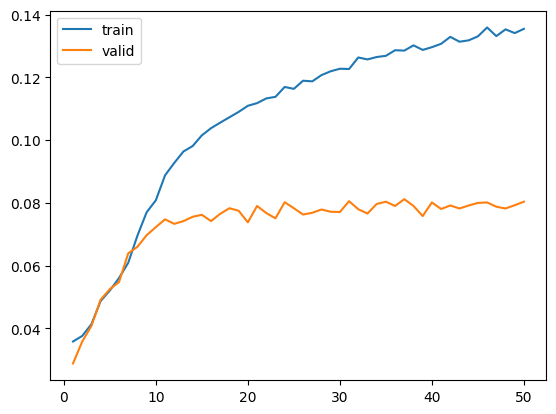

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
# import sys
# !{sys.executable} -m pip install gradio --quiet

In [ ]:
# import gradio as gr

# def model_response(human_text):

#     # Encodeamos
#     encoded = tok.texts_to_sequences([human_text])[0]
#     # Si tienen distinto largo
#     encoded = pad_sequences([encoded], maxlen=3, padding='pre')

#     # Predicción softmax
#     y_hat = model.predict(encoded).argmax(axis=-1)

#     # Debemos buscar en el vocabulario la palabra
#     # que corresopnde al indice (y_hat) predicho por le modelo
#     out_word = ''
#     for word, index in tok.word_index.items():
#         if index == y_hat:
#             out_word = word
#             break

#     # Agrego la palabra a la frase predicha
#     return human_text + ' ' + out_word

# iface = gr.Interface(
#     fn=model_response,
#     inputs=["textbox"],
#     outputs="text",
#     layout="vertical")

# iface.launch(debug=True)

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='han no puedes'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 20ms/step


'han no puedes al tambien de'

In [ ]:
input_text='luke has'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 29ms/step


'luke has ir la puedo'

In [ ]:
input_text='luke soy tu'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 42ms/step


'luke soy tu has vuelto '

In [ ]:
input_text='velocidad de la'

generate_seq(model, tok, input_text, max_length=3, n_words=1)

1/1 [==============================] - 0s 20ms/step


'velocidad de la puedo'

In [ ]:
input_text='droide'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 59ms/step


'droide de   '

In [ ]:
input_text='clones'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 18ms/step


'clones de no si'

In [ ]:
input_text='estrella de la'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 24ms/step


'estrella de la rojo que'

In [ ]:
input_text='lider rojo'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 24ms/step


'lider rojo que   '

In [ ]:
input_text='carreras de'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 18ms/step


'carreras de no   '

In [ ]:
input_text='la fuerza'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 24ms/step


'la fuerza de no si de'

In [ ]:
# se analisa la generacion de paralabras sobre personas
input_text='laia y luke'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 19ms/step


'laia y luke de no si de'

In [ ]:
# se analisa la generacion de paralabras sobre personas
input_text='darth vader y luke'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 20ms/step


'darth vader y luke de no si de'

In [ ]:
# se analisa la generacion de paralabras sobre personas
input_text='han solo y chewbacca'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 21ms/step


'han solo y chewbacca de no si de'

In [ ]:
input_text='los skywalker son'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 21ms/step


'los skywalker son    '

In [ ]:
input_text='el planeta es'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 31ms/step


'el planeta es es es es es'

In [ ]:
input_text='los reveldes son'

generate_seq(model, tok, input_text, max_length=3, n_words=7)

1/1 [==============================] - 0s 18ms/step


'los reveldes son averiguar de no    '

In [ ]:
input_text='el imperio'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 28ms/step


'el imperio de no si de'

In [ ]:
input_text='las naves'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 26ms/step


'las naves que de  '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

**Variaciones del modelo:**


*   Se realizaron entrenamientos con diferentes variaciones en la red:
Capa de embedding: aumentar el tamaño de esta no aporto mejoras en la validación de la red.
*   Capa bidireccional: la inclusión de una capa bidireccional presento mejoras en el modelo.

*   Cambio de capa de memoria: se cambiaron las capas LSTM por GRU, el modelo no presento diferencias en validación, pero si en cantidad de parámetros totales. Esto tiene sentido ya que a este modelo no se le pide utilizar las cualidades de memoria a largo plazo de LSTM y las GRU pueden satisfacer las características que se buscan.

*   Capas densas: Se agrego otra capa densa luego de las capas de memoria, esta capa densa tiene el mismo tamaño de neuronas que la última capa de memoria. Esto aporto mejoras en la validación del modelo.


**Análisis de resultados:**

El modelo presenta una tendencia un utilizar las palabras DE, NO, SI y ES sin mucha distinción. Hay casos donde la red puede generar oraciones con algún sentido, pero no llega a grandes resultados.
